<a href="https://colab.research.google.com/github/VictoorV/Mask_detection/blob/main/Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

100%|██████████| 398M/398M [00:03<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


# Extraire les données XML

In [149]:
import xml.etree.ElementTree as ET
import pandas as pd
import os

df = { 'filename': [],
     'width': [],
     'height': [],
     'label': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

path_xml = path + '/annotations/'
elements = os.listdir(path_xml)
for element in elements:
  tree = ET.parse(path_xml + element)
  root = tree.getroot()

  for object in root.findall('object'): # For one XML file, probably many objects
    df['filename'].append(root[1].text)
    df['width'].append(root[2][0].text)
    df['height'].append(root[2][1].text)
    df['label'].append(object[0].text)
    df['xmin'].append(object[-1][0].text)
    df['ymin'].append(object[-1][1].text)
    df['xmax'].append(object[-1][2].text)
    df['ymax'].append(object[-1][3].text)

df = pd.DataFrame(df)

In [150]:
df

,filename,width,height,label,xmin,ymin,xmax,ymax
0,maksssksksss431.png,400,226,mask_weared_incorrect,20,71,76,129
1,maksssksksss431.png,400,226,with_mask,150,114,197,171
2,maksssksksss431.png,400,226,with_mask,201,149,230,192
3,maksssksksss431.png,400,226,with_mask,241,153,291,205
4,maksssksksss431.png,400,226,with_mask,309,140,345,185
...,...,...,...,...,...,...,...,...
4067,maksssksksss294.png,400,241,without_mask,236,91,243,99
4068,maksssksksss294.png,400,241,without_mask,236,76,243,83
4069,maksssksksss294.png,400,241,with_mask,264,76,268,82
4070,maksssksksss294.png,400,241,with_mask,281,72,286,78


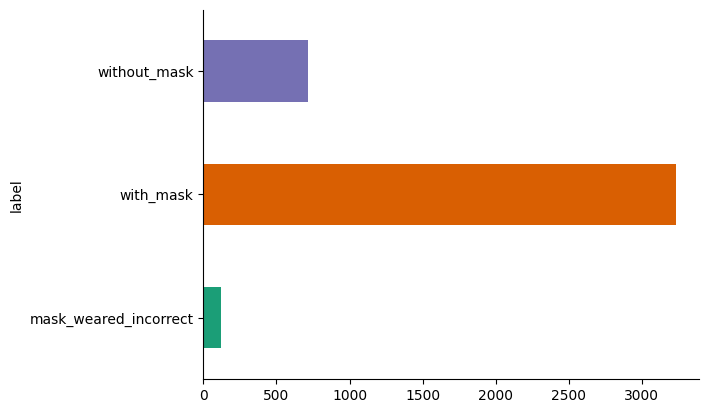

In [144]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [171]:
df['label'] = df['label'].replace({'without_mask' : 0,
                    'with_mask' : 1,
                    'mask_weared_incorrect' : 2})

<ipython-input-171-d8844236e260>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'without_mask' : 0,


## Train_set et val_set

In [173]:
from sklearn.model_selection import train_test_split

filenames = df['filename'].unique()
filenames_train, filenames_val = train_test_split(filenames, test_size=0.2, random_state=0)
print(f"Nombre d'images dans le train_set: {len(filenames_train)}")
print(f"Nombre d'images dans le val_set: {len(filenames_val)}")

Nombre d'images dans le train_set: 682
Nombre d'images dans le val_set: 171


In [174]:
df_train = df[df['filename'].isin(filenames_train)].copy()
df_train

,filename,width,height,label,xmin,ymin,xmax,ymax
0,maksssksksss431.png,400,226,2,20,71,76,129
1,maksssksksss431.png,400,226,1,150,114,197,171
2,maksssksksss431.png,400,226,1,201,149,230,192
3,maksssksksss431.png,400,226,1,241,153,291,205
4,maksssksksss431.png,400,226,1,309,140,345,185
...,...,...,...,...,...,...,...,...
4066,maksssksksss294.png,400,241,0,271,73,278,82
4067,maksssksksss294.png,400,241,0,236,91,243,99
4068,maksssksksss294.png,400,241,0,236,76,243,83
4069,maksssksksss294.png,400,241,1,264,76,268,82


In [175]:
df_test = df[df['filename'].isin(filenames_val)].copy()
df_test

,filename,width,height,label,xmin,ymin,xmax,ymax
13,maksssksksss841.png,301,400,0,134,184,223,296
19,maksssksksss231.png,400,249,1,9,55,29,79
20,maksssksksss231.png,400,249,1,32,50,56,74
21,maksssksksss231.png,400,249,1,102,26,120,49
22,maksssksksss231.png,400,249,1,87,73,105,99
...,...,...,...,...,...,...,...,...
4032,maksssksksss555.png,400,225,1,256,98,270,114
4033,maksssksksss555.png,400,225,1,310,108,327,130
4056,maksssksksss193.png,300,400,1,13,175,97,254
4057,maksssksksss193.png,300,400,1,133,56,258,172


# Mise au format YOLO

## Création des dossiers train/val et des fichiers .txt



```
dataset/
├── train/
│   ├── images/
│   │   ├── img1.jpg
│   │   ├── img2.jpg
│   ├── labels/
│       ├── img1.txt
│       ├── img2.txt
├── val/
│   ├── images/
│   ├── labels/
```



## Création des fichiers .yaml